<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


  Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.9 MB)
✨🍰✨ Everything looks OK!
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-f4cxrnpy
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-f4cxrnpy
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit efc711f35e19b9ca5c5d0da2f8812f4719d613a8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-pe2lbpsm/elegantrl_b1e328e6da2e4ede8c3


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.11/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [8]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2024-01-01'
TEST_START_DATE = '2024-01-01'
TEST_END_DATE = '2025-07-23'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (115013, 8)


In [9]:
df.head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.431895,6.446621,6.382907,6.414463,493729600,AAPL,0
1,2010-01-04,39.913254,40.016977,39.111116,39.159521,5277400,AMGN,0
2,2010-01-04,32.637962,32.781531,32.215233,32.550228,6894300,AXP,0
3,2010-01-04,43.777550,43.941189,42.702201,43.419101,6186700,BA,0
4,2010-01-04,39.403458,39.834170,38.703549,38.797770,7325600,CAT,0


In [11]:
df.tail(10)

Price,date,close,high,low,open,volume,tic,day
115003,2025-07-22,81.610001,81.769997,79.870003,79.870003,10571000,MRK,1
115004,2025-07-22,505.269989,511.200012,505.269989,510.970001,13868600,MSFT,1
115005,2025-07-22,75.389999,75.540001,74.040001,74.070000,11297500,NKE,1
115006,2025-07-22,158.320007,158.369995,154.899994,154.919998,8187000,PG,1
115007,2025-07-22,266.779999,267.779999,264.609985,264.679993,1412700,TRV,1
115008,2025-07-22,285.130005,287.109985,282.000000,282.630005,14600300,UNH,1
115009,2025-07-22,351.859985,354.480011,350.200012,351.100006,4614200,V,1
115010,2025-07-22,42.959999,43.490002,42.549999,42.750000,23521000,VZ,1
115011,2025-07-22,11.540000,11.590000,11.510000,11.520000,4801700,WBA,1
115012,2025-07-22,95.849998,96.669998,95.739998,95.839996,9049100,WMT,1


In [44]:
df.to_csv("dow30_1d.csv")

In [ ]:
df.shape

(97013, 8)

In [12]:
df.sort_values(['date','tic']).head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.431895,6.446621,6.382907,6.414463,493729600,AAPL,0
1,2010-01-04,39.913254,40.016977,39.111116,39.159521,5277400,AMGN,0
2,2010-01-04,32.637962,32.781531,32.215233,32.550228,6894300,AXP,0
3,2010-01-04,43.777550,43.941189,42.702201,43.419101,6186700,BA,0
4,2010-01-04,39.403458,39.834170,38.703549,38.797770,7325600,CAT,0


In [14]:
len(df.tic.unique())

30

In [15]:
df.tic.value_counts()

,count
tic,
AAPL,3911
AMGN,3911
AXP,3911
BA,3911
CAT,3911
CRM,3911
CSCO,3911
CVX,3911
DIS,3911


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [16]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [17]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [18]:
processed.sample(5)

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
71849,2019-11-05,43.922161,44.315970,43.670795,44.315970,19284000,KO,1,-0.143222,46.014868,44.104314,45.408293,-230.718056,21.648649,45.146033,45.268611,31.431938
23585,2013-03-28,50.789772,50.914958,50.521517,50.601994,6705600,DIS,3,0.425442,51.844276,49.592197,58.769804,50.489521,3.120698,50.080384,48.711534,23.618296
39584,2015-06-05,20.080061,20.412622,20.058075,20.385138,31905300,WMT,4,-0.354872,22.097419,19.857151,35.957388,-147.023426,44.246676,21.147990,21.631838,22.734161
76081,2020-06-05,127.806557,129.836882,127.199196,128.144944,9725400,JNJ,4,0.452464,130.217567,125.008006,52.577075,0.264079,12.141642,128.232857,122.593050,38.158583
39128,2015-05-14,69.829964,70.377275,69.553090,69.553090,9751700,CVX,3,0.019896,71.940808,68.599977,50.934351,-6.322289,16.452935,69.966259,68.903302,18.183268


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [19]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [20]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [21]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)



In [37]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 }

In [38]:
help(ensemble_agent.run_ensemble_strategy)

Help on method run_ensemble_strategy in module finrl.agents.stablebaselines3.models:

run_ensemble_strategy(A2C_model_kwargs, PPO_model_kwargs, DDPG_model_kwargs, SAC_model_kwargs, TD3_model_kwargs, timesteps_dict) method of finrl.agents.stablebaselines3.models.DRLEnsembleAgent instance



In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,PPO_model_kwargs,DDPG_model_kwargs,None, None,timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  200.92948365933947
======Model training from:  2010-01-01 to  2024-01-02
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_3


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


--------------------------------------
| time/                 |            |
|    fps                | 77         |
|    iterations         | 100        |
|    time_elapsed       | 6          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -0.42      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -28        |
|    reward             | 0.46784094 |
|    reward_max         | 2.0649967  |
|    reward_mean        | 0.72532976 |
|    reward_min         | 0.09971032 |
|    std                | 1          |
|    value_loss         | 0.979      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 83         |
|    iterations         | 200        |
|    time_elapsed       | 11         |
|    total_timesteps    | 1000       |
| train/                |

In [54]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2024-01-02,2024-04-03,SAC,0.10414,0.069558,0.083594,0.389429,0.282897
1,189,2024-04-03,2024-07-03,TD3,-0.230419,0.117282,-0.089637,-0.027368,0.262257
2,252,2024-07-03,2024-10-02,SAC,0.144607,0.413071,0.246575,0.448854,0.349175
3,315,2024-10-02,2025-01-02,TD3,0.076425,-0.019446,0.137034,0.034753,0.206821
4,378,2025-01-02,2025-04-04,DDPG,-0.147827,-0.203977,0.038301,-0.042618,-0.105999


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [55]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()
print(f'unique_trade_date={unique_trade_date}')

unique_trade_date=['2024-01-02' '2024-01-03' '2024-01-04' '2024-01-05' '2024-01-08'
 '2024-01-09' '2024-01-10' '2024-01-11' '2024-01-12' '2024-01-16'
 '2024-01-17' '2024-01-18' '2024-01-19' '2024-01-22' '2024-01-23'
 '2024-01-24' '2024-01-25' '2024-01-26' '2024-01-29' '2024-01-30'
 '2024-01-31' '2024-02-01' '2024-02-02' '2024-02-05' '2024-02-06'
 '2024-02-07' '2024-02-08' '2024-02-09' '2024-02-12' '2024-02-13'
 '2024-02-14' '2024-02-15' '2024-02-16' '2024-02-20' '2024-02-21'
 '2024-02-22' '2024-02-23' '2024-02-26' '2024-02-27' '2024-02-28'
 '2024-02-29' '2024-03-01' '2024-03-04' '2024-03-05' '2024-03-06'
 '2024-03-07' '2024-03-08' '2024-03-11' '2024-03-12' '2024-03-13'
 '2024-03-14' '2024-03-15' '2024-03-18' '2024-03-19' '2024-03-20'
 '2024-03-21' '2024-03-22' '2024-03-25' '2024-03-26' '2024-03-27'
 '2024-03-28' '2024-04-01' '2024-04-02' '2024-04-03' '2024-04-04'
 '2024-04-05' '2024-04-08' '2024-04-09' '2024-04-10' '2024-04-11'
 '2024-04-12' '2024-04-15' '2024-04-16' '2024-04-17' '2024

In [60]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
list_df_account_value=[]
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    print(temp)
    list_df_account_value.append(temp)
df_account_value = pd.concat(list_df_account_value,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

    account_value        date  daily_return
0    1.000000e+06  2024-04-03           NaN
1    9.955572e+05  2024-04-04     -0.004443
2    1.001358e+06  2024-04-05      0.005827
3    1.000093e+06  2024-04-08     -0.001264
4    1.000183e+06  2024-04-09      0.000090
..            ...         ...           ...
58   9.770932e+05  2024-06-26      0.001539
59   9.769853e+05  2024-06-27     -0.000110
60   9.723161e+05  2024-06-28     -0.004779
61   9.713438e+05  2024-07-01     -0.001000
62   9.717058e+05  2024-07-02      0.000373

[63 rows x 3 columns]
    account_value        date  daily_return
0    9.722523e+05  2024-07-03           NaN
1    9.728203e+05  2024-07-05      0.000584
2    9.747186e+05  2024-07-08      0.001951
3    9.749199e+05  2024-07-09      0.000206
4    9.885987e+05  2024-07-10      0.014031
..            ...         ...           ...
58   1.049116e+06  2024-09-25     -0.002461
59   1.052150e+06  2024-09-26      0.002892
60   1.055499e+06  2024-09-27      0.003183
61   1.05

In [64]:
df_account_value.head(10)

,account_value,date,daily_return,datadate
0,1.000000e+06,2024-04-03,NaN,2024-04-03
1,9.955572e+05,2024-04-04,-0.004443,2024-04-04
2,1.001358e+06,2024-04-05,0.005827,2024-04-05
3,1.000093e+06,2024-04-08,-0.001264,2024-04-08
4,1.000183e+06,2024-04-09,0.000090,2024-04-09
5,9.879340e+05,2024-04-10,-0.012247,2024-04-10
6,9.878085e+05,2024-04-11,-0.000127,2024-04-11
7,9.712349e+05,2024-04-12,-0.016778,2024-04-12
8,9.621848e+05,2024-04-15,-0.009318,2024-04-15
9,9.591297e+05,2024-04-16,-0.003175,2024-04-16


In [65]:
df_account_value.tail(10)

,account_value,date,daily_return,datadate
305,951317.397154,2025-06-23,0.011125,2025-06-23
306,959310.728104,2025-06-24,0.008402,2025-06-24
307,953956.654816,2025-06-25,-0.005581,2025-06-25
308,958226.983616,2025-06-26,0.004476,2025-06-26
309,963615.212500,2025-06-27,0.005623,2025-06-27
310,970779.395323,2025-06-30,0.007435,2025-06-30
311,979167.870844,2025-07-01,0.008641,2025-07-01
312,958327.954157,2025-07-02,-0.021283,2025-07-02
313,968980.879092,2025-07-03,0.011116,2025-07-03
314,962653.539196,2025-07-07,-0.006530,2025-07-07


<Axes: >

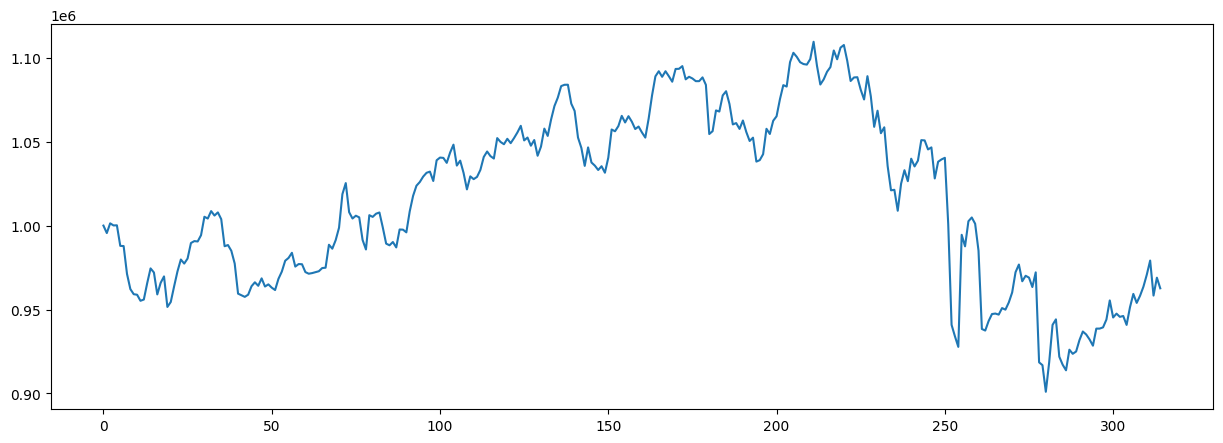

In [73]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [67]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.029990
Cumulative returns    -0.037346
Annual volatility      0.166284
Sharpe ratio          -0.100424
Calmar ratio          -0.159600
Stability              0.000675
Max drawdown          -0.187911
Omega ratio            0.980297
Sortino ratio         -0.132061
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.781402
Daily value at risk   -0.021016
dtype: float64


In [68]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (314, 8)
Annual return          0.115351
Cumulative returns     0.145714
Annual volatility      0.163103
Sharpe ratio           0.752550
Calmar ratio           0.704683
Stability              0.377798
Max drawdown          -0.163692
Omega ratio            1.153789
Sortino ratio          1.111840
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.867141
Daily value at risk   -0.020062
dtype: float64


In [72]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2024-04-03  1.000000e+06
1    2024-04-04  9.864503e+05
2    2024-04-05  9.942980e+05
3    2024-04-08  9.940108e+05
4    2024-04-09  9.937775e+05
..          ...           ...
310  2025-06-30  1.126961e+06
311  2025-07-01  1.137189e+06
312  2025-07-02  1.136920e+06
313  2025-07-03  1.145714e+06
314  2025-07-07           NaN

[315 rows x 2 columns]
df_dji:                       dji
date                    
2024-04-03  1.000000e+06
2024-04-04  9.864503e+05
2024-04-05  9.942980e+05
2024-04-08  9.940108e+05
2024-04-09  9.937775e+05
...                  ...
2025-06-30  1.126961e+06
2025-07-01  1.137189e+06
2025-07-02  1.136920e+06
2025-07-03  1.145714e+06
2025-07-07           NaN

[315 rows x 1 columns]


<a id='6.2'></a>
## 7.2 BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2024-01-02
1    2024-01-03
2    2024-01-04
3    2024-01-05
4    2024-01-08
..          ...
384  2025-07-16
385  2025-07-17
386  2025-07-18
387  2025-07-21
388  2025-07-22

[389 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2024-04-03  1.000000e+06
2024-04-04  9.955572e+05
2024-04-05  1.001358e+06
2024-04-08  1.000093e+06
2024-04-09  1.000183e+06
...                  ...
2025-06-30  9.707794e+05
2025-07-01  9.791679e+05
2025-07-02  9.583280e+05
2025-07-03  9.689809e+05
2025-07-07  9.626535e+05

[315 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2024-04-03  1.000000e+06  1.000000e+06
2024-04-04  9.955572e+05  9.864503e+05
2024-04-05  1.001358e+06  9.942980e+05
2024-04-08  1.000093e+06  9.940108e+05
2024-04-09  1.000183e+06  9.937775e+05
...       

<Figure size 1500x500 with 0 Axes>

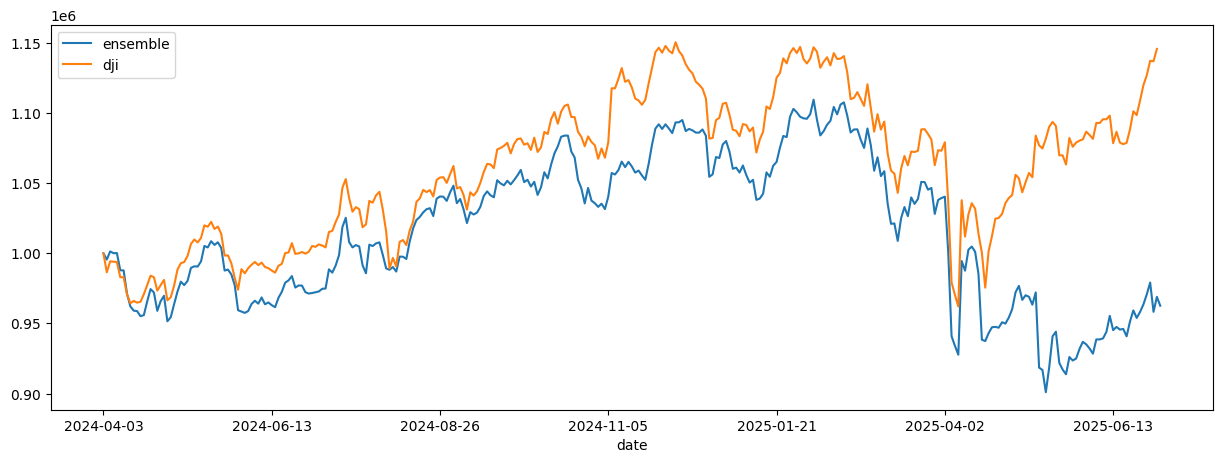

In [71]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();